# Actividad práctica: Predicción de series de tiempo

En esta tarea se pide entrenar y evaluar un predictor para la serie de tiempo Mackey-Glass. Esta serie de tiempo se obtiene de la solución de la siguiente ecuación diferencial

$$
\frac{dy}{dt} = 0.2 \frac{ y(t-\tau)}{1 + y(t-\tau)^{10}} - 0.1 y(t),
$$

donde el parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo 

- Siga las instrucciones en este notebook para resolver el problema de predicción
- Conteste las preguntas que se encuentran en este enunciado
- Finalmente envíe su notebook con los resultados y respuestas a phuijse@inf.uach.cl
- No olvide cambiar el título para reflejar los integrantes de su grupo

In [2]:
import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt

***

Use el código que se muestra a continuación para generar la serie de tiempo Mackey Glass

- Considere una razón señal a ruido (SNR) de 10
- Considere $\tau=17$ (comportamiento debilmente caótico)

Se generaran 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar y los siguientes 500 puntos para hacer predicción

<IPython.core.display.Javascript object>


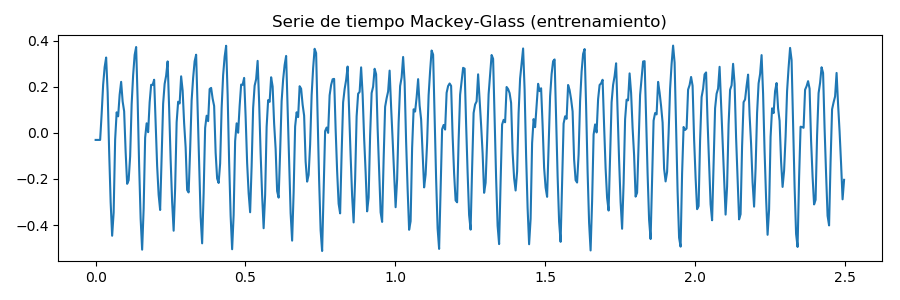

In [188]:
# número de observaciones (no modificar)
N = 1000
# Razón señal a ruido (10, 1, 0.1)
SNR = 10.
# constantes de la ecuación diferencial (no modificar)
a, b = 0.1, 0.2
# comportamiento dinámico de Mackey-Glass (17, 30)
tau = 17.
# paso de integración (no modificar)
dt = 0.05
# condición incial (no modificar)
y0 = 0.9
# largo temporal (no modificar)
tt = 5.
t = np.linspace(0, tt, num=N)

N_full, tau_full = int(N*tt/dt), int(tau/dt)
ymg = y0*np.ones(shape=(N_full, ))
# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+xk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+xk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+xk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;
ymg = ymg[::int(tt/dt)]
ymg = ymg - np.mean(ymg) 
# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/10.**SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))
# Gráfico
fig, ax = plt.subplots(1, figsize=(9, 3), tight_layout=True)
ax.plot(t[:500], y_obs[:500])
ax.set_title('Serie de tiempo Mackey-Glass (entrenamiento)');

***

1. Describa en detalle el algoritmo LMS indicando sus semejanzas y diferencias con el filtro de Wiener 
1. Partiendo del error instantaneo $J_n^s(\textbf{w}) = e_n^2$ derive la regla de actualización de pesos
1. La siguiente clase de *Python* predice y entrena un filtro LMS. Complete la linea que dice 

` self.w += ? `

con el valor correcto de actualización de peso del filtro LMS

In [183]:
class LMS_filter(object):
    
    def __init__(self, L=1, mu=0.5, normalized=True):
        self.L = L
        self.mu = mu
        self.w = np.zeros(shape=(L, ))
        self.normalized = normalized
    
    def __len__(self):
        return self.L
    
    def predict(self, u):
        return np.dot(self.w, u)
    
    def update(self, u, d):
        u_pred = self.predict(u)
        norm = 1.
        if self.normalized:
            norm = np.sum(u**2) + 1e-6
        self.w  += 2*self.mu*(d - u_pred)*u/norm

1. Entrene el predictor con el algoritmo normalized LMS usando el siguiente bloque de código y asumiendo $L=50$
1. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\mu$
1. Describa cada experimento 
    - ¿Cuánto demora el filtro en estabilizarse? 
    - ¿Se sobreajuste el filtro a los datos de entrenamiento? 
    - ¿Se desestabiliza el filtro?
1. Indique que combinación obtiene menor MSE de prueba y 
1. Repita el experimento para para SNR = 1.0 y luego SNR = 0.1

<IPython.core.display.Javascript object>


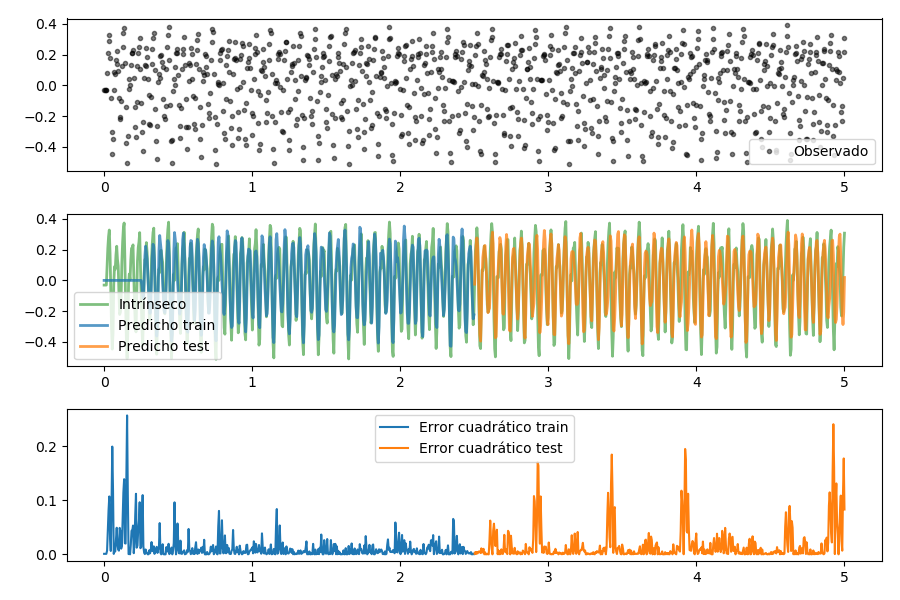

MSE entrenamiento 80.0514, prueba 170.1968


In [196]:
lms = LMS_filter(L=50, mu=0.2, normalized=True)
# Entrenamiento
y_pred = np.zeros(shape=(len(y), ))
for k in range(lms.__len__(), 500):
    y_window = y_obs[k-lms.__len__():k]
    y_pred[k] = lms.predict(y_window)
    lms.update(d=y_obs[k], u=y_window)
# Prueba
for k in range(500, len(y)):
    y_window = y_obs[k-lms.__len__():k]
    y_pred[k] = lms.predict(y_window)

fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

***

<h1><center><u>Problema 2: KRLS </u></center></h1>

KRLS es una versión no lineal del algoritmo de mínimos cuadrados recursivo. El algoritmo KRLS realiza una regresión lineal en un espacio de características de alta dimensionalidad inducido por un kernel, y puede ser usado para construir recursivamente un regresor de mínimo MSE. En esta tarea se pide predecir la serie de tiempo de Mackey-Glass. Esta serie de tiempo puede generarse mediante integración numérica de la siguiente ecuación diferencial 

$$
\frac{dy}{dt} = \frac{a y(t-\tau)}{1 + y(t-\tau)^{10}} -b y(t),
$$

donde se considerará $a=0.2$ y $b=0.1$. El parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo. Para $\tau > 16.8$ la dinámica se vuelve caótica. En particular se considerarán los valores $\tau = 17$ y $\tau = 30$ para definir comportamientos débilmente caótico y fuertemente caótico, respectivamente. 

Para entrenar el regresor minimice el error de predicción de 1 punto usando los siguientes ejemplos de entrenamiento: $\{(x_i , y_i )\}_{i=1}^N$ con $x_i = (y_{i-m},y_{i-2 m},\ldots,y_{i-d m})$, donde N es el número de ejemplos de entrenamiento, $d$ es la dimensión del embedding y $m$ es el retardo del embedding. Para esta tarea use $m=1$ y $d=7$, para generar conjuntos de entrenamiento y prueba de 3000 y 1000 muestras, respectivamente. 

Se le llama diccionario al conjunto de muestras que forman el conocimiento aprendido por el regresor. En esta tarea, sólo muestras cuyo vector de características no pueda aproximarse por muestras anteriores serán admitidas al diccionario. El criterio usado para evaluar una nueva muestra $x_t$ es la condición de dependencia lineal (ALD por su sigla en ingles) definida como
$$
\delta_t = \min_{\vec a} \left\| \sum_{j=1}^{m_t} a_j \phi (x_j) -\phi(x_t) \right\|^2 < \nu,
$$
donde $\nu$ es el nivel de dispersión (sparsification level). Si existe un set de coeficientes $\vec a$ tal que $\delta_t < \nu$ (se cumple la condición ALD) entonces la muestra $x_t$ no se añade al diccionario. En esta tarea usted usará el algoritmo ALD-KRLS para entrenar predictores de un punto. Considere un kernel Gaussiano para KRLS y un tamaño de diccionario de 100. Las actividades a realizar se detallan a continuación.


1. Utilice el algoritmo ALD-RLS (lineal) para entrenar un predictor de 1 punto que sea óptimo en el sentido de mínimos cuadrados. Considere un valor $\tau=17$ (comportamiento débilmente caótico) para la función generadora. Explore la influencia del nivel de dispersión ($\nu$). Encuentre el mejor valor para el parámetro $\nu$, es decir aquel que minimiza el MSE de predicción. Considere los siguientes valores de $\nu = \{10^{-6}, 10^{-4}, 10^{-2}, 1\}$, para iniciar su búsqueda (se espera que usted realice una búsqueda más fina en los rangos que considere adecuados). Considere los mejores resultados obtenidos como referencia para su análisis en los puntos siguientes.

1. Utilice el algoritmo ALD-KRLS (no lineal) para entrenar un predictor de 1 punto que sea óptimo en el sentido de mínimos cuadrados. Considere un valor $\tau=17$ para la función generadora. Explore la influencia del nivel de dispersión ($\nu$) y del ancho de banda del kernel Gaussiano ($\sigma$). Encuentre la mejor combinación de los parámetros $\nu$ y $\sigma$, es decir aquella que minimiza el MSE de predicción. Considere las combinaciones dadas por $\sigma = \{10^{-2}, 10^{-1}, 1, 10, 100\}$ y $\nu = \{10^{-6}, 10^{-4}, 10^{-2}, 1\}$ para iniciar su búsqueda.  Compare con los resultados obtenidos en el punto anterior.

1. Explique las relaciones entre $\nu$, $\sigma$, el tamaño de diccionario y la capacidad de generalización del regresor. ¿Por qué es importante una solución dispersa (sparse) cuando se entrena un regresor? Mencione las dos ventajas claves de una solución dispersa. ¿Qué ventajas tiene un regresor no lineal basado en funciones de kernel sobre un regresor lineal? 

1. Repita el análisis realizado (sólo KRLS) hasta ahora considerando un valor $\tau=30$ (comportamiento fuertemente caótico) en la función generadora. Repita el punto 2 utilizando el nuevo valor de $\tau$. Compare con los resultados obtenidos usando $\tau=17$ y comente respecto a las diferencias encontradas.